In [1]:
pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib nibabel torch numpy scikit-learn scipy

Note: you may need to restart the kernel to use updated packages.


In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import nibabel as nib
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from monai.networks.nets import resnet10, resnet18, resnet34
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstD, ScaleIntensityD, EnsureTyped, RandFlipD, RandRotate90D, ResizeD # Updated import
from monai.data import CacheDataset, DataLoader, Dataset
from monai.losses import DiceLoss
from monai.metrics import compute_dice
from monai.config import print_config
class Generator3D(nn.Module):
    def __init__(self, z_dim=100, out_channels=1):
        super(Generator3D, self).__init__()
        self.fc = nn.Linear(z_dim, 256 * 4 * 4 * 4)
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose3d(32, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm3d(128)
        self.bn2 = nn.BatchNorm3d(64)
        self.bn3 = nn.BatchNorm3d(32)

    def forward(self, x):
        x = self.fc(x).view(-1, 256, 4, 4, 4)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = torch.tanh(self.deconv4(x))
        return x

class Discriminator3D(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(256 * 4 * 4 * 4, 1)
        self.bn1 = nn.BatchNorm3d(64)
        self.bn2 = nn.BatchNorm3d(128)
        self.bn3 = nn.BatchNorm3d(256)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn1(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv4(x)), 0.2)
        x = x.view(-1, 256 * 4 * 4 * 4)
        x = torch.sigmoid(self.fc(x))
        return x

# Define transformations
train_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstD(keys=["image"]),
    ScaleIntensityD(keys=["image"]),
    RandFlipD(keys=["image"], prob=0.5),
    RandRotate90D(keys=["image"], prob=0.5),
    ResizeD(keys=["image"], spatial_size=(64, 64, 64)),
    EnsureTyped(keys=["image"])
])

val_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstD(keys=["image"]),
    ScaleIntensityD(keys=["image"]),
    ResizeD(keys=["image"], spatial_size=(64, 64, 64)),
    EnsureTyped(keys=["image"])
])

# Dataset class
class GliomaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        data = {'image': image_path}
        if self.transform:
            data = self.transform(data)
        image = data['image']
        return image, label



2024-06-29 09:01:05.921837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 09:01:05.921951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 09:01:06.063474: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:

# Load and process your data
labels_df = pd.read_csv("/kaggle/input/tumorfyp/train_labels.csv")
patient_ids = labels_df["BraTS21ID"].tolist()
labels = labels_df["MGMT_value"].tolist()
data_folder = "/kaggle/input/tumorfyp/train/train"
data = []
data_labels = []

for patient_id, label in zip(patient_ids, labels):
    formatted_patient_id = str(patient_id).zfill(5)
    patient_folder = os.path.join(data_folder, f"{formatted_patient_id}")
    for scan_folder in ["FLAIR", 'T1w', 'T1wCE', 'T2w']:
        scan_path = os.path.join(patient_folder, scan_folder)
        nifti_files = [file for file in os.listdir(scan_path) if file.endswith('.nii')]
        if len(nifti_files) > 0:
            nifti_file_path = os.path.join(scan_path, nifti_files[0])
            data.append(nifti_file_path)
            data_labels.append(label)
        else:
            print(f"No NIfTI files found in {scan_folder} for patient {formatted_patient_id}")

# Split dataset into train and validation
train_files, val_files, train_labels, val_labels = train_test_split(data, data_labels, test_size=0.3, random_state=42)
# Divide the dataset into subsets based on labels
label_0_files = [file for file, label in zip(data, data_labels) if label == 0]
label_0_labels = [0] * len(label_0_files)

label_1_files = [file for file, label in zip(data, data_labels) if label == 1]
label_1_labels = [1] * len(label_1_files)

train_ds = GliomaDataset(train_files, train_labels, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4)

val_ds = GliomaDataset(val_files, val_labels, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=8, num_workers=4)

import torch.optim as optim
from tqdm import tqdm

# Specify device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Define device


# Initialize models and optimizers
z_dim = 100
generator = Generator3D(z_dim).to(device)
discriminator = Discriminator3D().to(device)
g_optimizer = optim.Adam(generator.parameters(), lr=5e-3, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()


In [5]:
import nibabel as nib
import numpy as np
import os
def train_gan(train_loader, z_dim=100, num_epochs=2, batch_size=8):
    # Define the models and optimizers
    generator = Generator3D(z_dim).to(device)
    discriminator = Discriminator3D().to(device)
    g_optimizer = optim.Adam(generator.parameters(), lr=5e-3, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

    # Loss function
    criterion = nn.BCELoss()

    # Training loop
    for epoch in range(num_epochs):
        for real_images, _ in tqdm(train_loader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Feature scaling for real images
            real_images = (real_images - torch.min(real_images)) / (torch.max(real_images) - torch.min(real_images))

            # Train Discriminator
            z = torch.randn(batch_size, z_dim).to(device)
            fake_images = generator(z)

            # Feature scaling for fake images
            fake_images = (fake_images - torch.min(fake_images)) / (torch.max(fake_images) - torch.min(fake_images))

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            d_optimizer.zero_grad()
            real_outputs = discriminator(real_images)
            d_real_loss = criterion(real_outputs, real_labels)
            fake_outputs = discriminator(fake_images.detach())
            d_fake_loss = criterion(fake_outputs, fake_labels)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            fake_outputs = discriminator(fake_images)
            g_loss = criterion(fake_outputs, real_labels)
            g_loss.backward()
            g_optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}]  Loss D: {d_loss.item():.4f}, loss G: {g_loss.item():.4f}")

    return generator
# Define transformations
train_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstD(keys=["image"]),
    ScaleIntensityD(keys=["image"]),
    RandFlipD(keys=["image"], prob=0.5),
    RandRotate90D(keys=["image"], prob=0.5),
    ResizeD(keys=["image"], spatial_size=(64, 64, 64)),
    EnsureTyped(keys=["image"])
])

# Subset for label 0
train_ds_0 = GliomaDataset(label_0_files, label_0_labels, transform=train_transforms)
train_loader_0 = DataLoader(train_ds_0, batch_size=8, shuffle=True, num_workers=4)

# Subset for label 1
train_ds_1 = GliomaDataset(label_1_files, label_1_labels, transform=train_transforms)
train_loader_1 = DataLoader(train_ds_1, batch_size=8, shuffle=True, num_workers=4)

# Train GANs
generator_0 = train_gan(train_loader_0, z_dim=100, num_epochs=100, batch_size=8)
generator_1 = train_gan(train_loader_1, z_dim=100, num_epochs=100, batch_size=8)
# Function to generate and save synthetic data
def generate_and_save_synthetic_data(generator, num_samples, z_dim, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    generator.eval()
    synthetic_image_paths = []
    with torch.no_grad():
        for i in range(num_samples):
            z = torch.randn(1, z_dim).to(device)
            synthetic_image = generator(z).cpu().numpy().squeeze()
            
            # Feature scaling for synthetic images
            synthetic_image = (synthetic_image - np.min(synthetic_image)) / (np.max(synthetic_image) - np.min(synthetic_image))

            synthetic_image_path = os.path.join(save_dir, f"synthetic_image_{i}.nii")
            nib.save(nib.Nifti1Image(synthetic_image, np.eye(4)), synthetic_image_path)
            synthetic_image_paths.append(synthetic_image_path)

    return synthetic_image_paths

# Generate synthetic data for label 0
synthetic_save_dir_0 = "synthetic_data_0"
num_synthetic_samples_0 = 5000  # Number of synthetic samples to generate
synthetic_image_paths_0 = generate_and_save_synthetic_data(generator_0, num_synthetic_samples_0, z_dim=100, save_dir=synthetic_save_dir_0)

# Generate synthetic data for label 1
synthetic_save_dir_1 = "synthetic_data_1"
num_synthetic_samples_1 = 5000  # Number of synthetic samples to generate
synthetic_image_paths_1 = generate_and_save_synthetic_data(generator_1, num_synthetic_samples_1, z_dim=100, save_dir=synthetic_save_dir_1)




  0%|          | 0/138 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 99%|█████████▉| 137/138 [00:13<00:00, 12.77it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 138/138 [00:13<00:00, 10.01it/s]


Epoch [1/100]  Loss D: 1.5654, loss G: 0.6122


100%|██████████| 138/138 [00:11<00:00, 11.88it/s]


Epoch [2/100]  Loss D: 1.4016, loss G: 0.8791


100%|██████████| 138/138 [00:11<00:00, 11.80it/s]


Epoch [3/100]  Loss D: 1.6177, loss G: 0.8780


100%|██████████| 138/138 [00:11<00:00, 11.62it/s]


Epoch [4/100]  Loss D: 1.3663, loss G: 0.9164


100%|██████████| 138/138 [00:11<00:00, 11.84it/s]


Epoch [5/100]  Loss D: 1.4887, loss G: 0.7951


100%|██████████| 138/138 [00:11<00:00, 11.51it/s]


Epoch [6/100]  Loss D: 1.4719, loss G: 0.9062


100%|██████████| 138/138 [00:11<00:00, 11.95it/s]


Epoch [7/100]  Loss D: 1.6585, loss G: 0.7065


100%|██████████| 138/138 [00:11<00:00, 11.90it/s]


Epoch [8/100]  Loss D: 1.4306, loss G: 0.7458


100%|██████████| 138/138 [00:11<00:00, 11.54it/s]


Epoch [9/100]  Loss D: 1.5374, loss G: 0.7654


100%|██████████| 138/138 [00:11<00:00, 11.94it/s]


Epoch [10/100]  Loss D: 1.4554, loss G: 0.7060


100%|██████████| 138/138 [00:11<00:00, 11.82it/s]


Epoch [11/100]  Loss D: 1.3113, loss G: 0.8109


100%|██████████| 138/138 [00:11<00:00, 11.56it/s]


Epoch [12/100]  Loss D: 1.3875, loss G: 0.8055


100%|██████████| 138/138 [00:11<00:00, 11.81it/s]


Epoch [13/100]  Loss D: 1.4302, loss G: 0.7867


100%|██████████| 138/138 [00:11<00:00, 11.65it/s]


Epoch [14/100]  Loss D: 1.3460, loss G: 0.8666


100%|██████████| 138/138 [00:11<00:00, 11.83it/s]


Epoch [15/100]  Loss D: 1.3348, loss G: 0.8461


100%|██████████| 138/138 [00:11<00:00, 12.01it/s]


Epoch [16/100]  Loss D: 1.1928, loss G: 0.9680


100%|██████████| 138/138 [00:12<00:00, 11.49it/s]


Epoch [17/100]  Loss D: 1.5226, loss G: 0.7702


100%|██████████| 138/138 [00:11<00:00, 11.82it/s]


Epoch [18/100]  Loss D: 1.5502, loss G: 0.7800


100%|██████████| 138/138 [00:11<00:00, 11.85it/s]


Epoch [19/100]  Loss D: 1.4120, loss G: 0.9241


100%|██████████| 138/138 [00:11<00:00, 11.54it/s]


Epoch [20/100]  Loss D: 1.4794, loss G: 0.7920


100%|██████████| 138/138 [00:11<00:00, 11.95it/s]


Epoch [21/100]  Loss D: 1.4009, loss G: 0.9470


100%|██████████| 138/138 [00:11<00:00, 12.09it/s]


Epoch [22/100]  Loss D: 1.4005, loss G: 0.8004


100%|██████████| 138/138 [00:11<00:00, 11.73it/s]


Epoch [23/100]  Loss D: 1.4290, loss G: 1.0999


100%|██████████| 138/138 [00:11<00:00, 12.15it/s]


Epoch [24/100]  Loss D: 1.5304, loss G: 0.8137


100%|██████████| 138/138 [00:11<00:00, 12.03it/s]


Epoch [25/100]  Loss D: 1.3499, loss G: 1.1828


100%|██████████| 138/138 [00:11<00:00, 11.81it/s]


Epoch [26/100]  Loss D: 1.2069, loss G: 1.1649


100%|██████████| 138/138 [00:11<00:00, 12.14it/s]


Epoch [27/100]  Loss D: 1.2705, loss G: 0.9249


100%|██████████| 138/138 [00:11<00:00, 11.71it/s]


Epoch [28/100]  Loss D: 1.4132, loss G: 0.8770


100%|██████████| 138/138 [00:11<00:00, 11.91it/s]


Epoch [29/100]  Loss D: 1.4149, loss G: 0.8289


100%|██████████| 138/138 [00:11<00:00, 12.19it/s]


Epoch [30/100]  Loss D: 1.4168, loss G: 0.8778


100%|██████████| 138/138 [00:11<00:00, 11.53it/s]


Epoch [31/100]  Loss D: 1.3945, loss G: 0.8191


100%|██████████| 138/138 [00:11<00:00, 12.07it/s]


Epoch [32/100]  Loss D: 1.1125, loss G: 1.1547


100%|██████████| 138/138 [00:11<00:00, 12.15it/s]


Epoch [33/100]  Loss D: 1.3178, loss G: 0.8635


100%|██████████| 138/138 [00:11<00:00, 11.58it/s]


Epoch [34/100]  Loss D: 1.6453, loss G: 0.9145


100%|██████████| 138/138 [00:11<00:00, 12.10it/s]


Epoch [35/100]  Loss D: 1.3959, loss G: 1.1115


100%|██████████| 138/138 [00:11<00:00, 11.98it/s]


Epoch [36/100]  Loss D: 1.0279, loss G: 1.2865


100%|██████████| 138/138 [00:11<00:00, 11.55it/s]


Epoch [37/100]  Loss D: 1.7352, loss G: 0.9739


100%|██████████| 138/138 [00:11<00:00, 12.03it/s]


Epoch [38/100]  Loss D: 1.1899, loss G: 1.0591


100%|██████████| 138/138 [00:11<00:00, 11.66it/s]


Epoch [39/100]  Loss D: 1.3230, loss G: 1.0672


100%|██████████| 138/138 [00:11<00:00, 12.04it/s]


Epoch [40/100]  Loss D: 1.2094, loss G: 0.9683


100%|██████████| 138/138 [00:11<00:00, 12.20it/s]


Epoch [41/100]  Loss D: 1.1092, loss G: 1.3011


100%|██████████| 138/138 [00:11<00:00, 11.61it/s]


Epoch [42/100]  Loss D: 1.1800, loss G: 1.1308


100%|██████████| 138/138 [00:11<00:00, 12.11it/s]


Epoch [43/100]  Loss D: 0.8085, loss G: 1.7200


100%|██████████| 138/138 [00:11<00:00, 11.87it/s]


Epoch [44/100]  Loss D: 1.0568, loss G: 1.4475


100%|██████████| 138/138 [00:11<00:00, 11.74it/s]


Epoch [45/100]  Loss D: 1.0869, loss G: 1.0081


100%|██████████| 138/138 [00:11<00:00, 12.18it/s]


Epoch [46/100]  Loss D: 1.1411, loss G: 1.5916


100%|██████████| 138/138 [00:11<00:00, 12.02it/s]


Epoch [47/100]  Loss D: 1.1535, loss G: 1.7376


100%|██████████| 138/138 [00:11<00:00, 11.72it/s]


Epoch [48/100]  Loss D: 0.8061, loss G: 2.5732


100%|██████████| 138/138 [00:11<00:00, 12.01it/s]


Epoch [49/100]  Loss D: 1.1533, loss G: 1.5634


100%|██████████| 138/138 [00:11<00:00, 12.00it/s]


Epoch [50/100]  Loss D: 0.6615, loss G: 2.6751


100%|██████████| 138/138 [00:11<00:00, 11.93it/s]


Epoch [51/100]  Loss D: 0.6858, loss G: 2.0960


100%|██████████| 138/138 [00:11<00:00, 11.93it/s]


Epoch [52/100]  Loss D: 0.4684, loss G: 2.6167


100%|██████████| 138/138 [00:11<00:00, 11.73it/s]


Epoch [53/100]  Loss D: 0.6192, loss G: 2.8362


100%|██████████| 138/138 [00:11<00:00, 12.09it/s]


Epoch [54/100]  Loss D: 0.5653, loss G: 2.5311


100%|██████████| 138/138 [00:11<00:00, 11.89it/s]


Epoch [55/100]  Loss D: 0.5228, loss G: 2.2974


100%|██████████| 138/138 [00:11<00:00, 11.58it/s]


Epoch [56/100]  Loss D: 0.5716, loss G: 1.8327


100%|██████████| 138/138 [00:11<00:00, 11.97it/s]


Epoch [57/100]  Loss D: 0.4620, loss G: 2.9644


100%|██████████| 138/138 [00:11<00:00, 12.02it/s]


Epoch [58/100]  Loss D: 0.4908, loss G: 2.8987


100%|██████████| 138/138 [00:11<00:00, 11.63it/s]


Epoch [59/100]  Loss D: 0.4589, loss G: 2.2819


100%|██████████| 138/138 [00:11<00:00, 11.97it/s]


Epoch [60/100]  Loss D: 0.2072, loss G: 2.7670


100%|██████████| 138/138 [00:11<00:00, 12.13it/s]


Epoch [61/100]  Loss D: 0.4554, loss G: 3.3658


100%|██████████| 138/138 [00:11<00:00, 11.69it/s]


Epoch [62/100]  Loss D: 0.4464, loss G: 2.6861


100%|██████████| 138/138 [00:11<00:00, 11.97it/s]


Epoch [63/100]  Loss D: 0.9195, loss G: 3.1666


100%|██████████| 138/138 [00:11<00:00, 11.68it/s]


Epoch [64/100]  Loss D: 0.4062, loss G: 2.6476


100%|██████████| 138/138 [00:11<00:00, 12.03it/s]


Epoch [65/100]  Loss D: 0.6181, loss G: 4.0868


100%|██████████| 138/138 [00:11<00:00, 12.00it/s]


Epoch [66/100]  Loss D: 0.4298, loss G: 3.4047


100%|██████████| 138/138 [00:11<00:00, 11.69it/s]


Epoch [67/100]  Loss D: 0.1295, loss G: 3.2755


100%|██████████| 138/138 [00:11<00:00, 11.87it/s]


Epoch [68/100]  Loss D: 0.4130, loss G: 3.1141


100%|██████████| 138/138 [00:11<00:00, 12.18it/s]


Epoch [69/100]  Loss D: 0.3371, loss G: 3.2786


100%|██████████| 138/138 [00:11<00:00, 11.57it/s]


Epoch [70/100]  Loss D: 0.7832, loss G: 2.2394


100%|██████████| 138/138 [00:11<00:00, 11.91it/s]


Epoch [71/100]  Loss D: 0.3086, loss G: 3.5952


100%|██████████| 138/138 [00:11<00:00, 12.15it/s]


Epoch [72/100]  Loss D: 0.2389, loss G: 3.3622


100%|██████████| 138/138 [00:11<00:00, 11.73it/s]


Epoch [73/100]  Loss D: 0.4454, loss G: 3.7859


100%|██████████| 138/138 [00:11<00:00, 11.93it/s]


Epoch [74/100]  Loss D: 0.6389, loss G: 4.3340


100%|██████████| 138/138 [00:11<00:00, 11.76it/s]


Epoch [75/100]  Loss D: 0.3870, loss G: 3.3827


100%|██████████| 138/138 [00:11<00:00, 11.94it/s]


Epoch [76/100]  Loss D: 0.1509, loss G: 3.8404


100%|██████████| 138/138 [00:11<00:00, 12.10it/s]


Epoch [77/100]  Loss D: 0.6282, loss G: 3.3393


100%|██████████| 138/138 [00:11<00:00, 11.63it/s]


Epoch [78/100]  Loss D: 0.5230, loss G: 4.6794


100%|██████████| 138/138 [00:11<00:00, 11.90it/s]


Epoch [79/100]  Loss D: 0.2021, loss G: 2.9472


100%|██████████| 138/138 [00:11<00:00, 12.10it/s]


Epoch [80/100]  Loss D: 0.6475, loss G: 2.3934


100%|██████████| 138/138 [00:11<00:00, 11.56it/s]


Epoch [81/100]  Loss D: 0.2442, loss G: 3.5948


100%|██████████| 138/138 [00:11<00:00, 11.53it/s]


Epoch [82/100]  Loss D: 0.3315, loss G: 3.5107


100%|██████████| 138/138 [00:11<00:00, 11.84it/s]


Epoch [83/100]  Loss D: 0.2006, loss G: 4.0788


100%|██████████| 138/138 [00:12<00:00, 11.28it/s]


Epoch [84/100]  Loss D: 0.1910, loss G: 3.5523


100%|██████████| 138/138 [00:11<00:00, 11.77it/s]


Epoch [85/100]  Loss D: 0.3646, loss G: 4.7884


100%|██████████| 138/138 [00:12<00:00, 10.91it/s]


Epoch [86/100]  Loss D: 0.1619, loss G: 5.2587


100%|██████████| 138/138 [00:12<00:00, 10.71it/s]


Epoch [87/100]  Loss D: 1.1567, loss G: 6.2755


100%|██████████| 138/138 [00:12<00:00, 10.73it/s]


Epoch [88/100]  Loss D: 0.3160, loss G: 4.5886


100%|██████████| 138/138 [00:13<00:00, 10.37it/s]


Epoch [89/100]  Loss D: 0.5969, loss G: 4.1310


100%|██████████| 138/138 [00:11<00:00, 11.92it/s]


Epoch [90/100]  Loss D: 0.9417, loss G: 1.5390


100%|██████████| 138/138 [00:11<00:00, 12.01it/s]


Epoch [91/100]  Loss D: 0.7333, loss G: 2.3744


100%|██████████| 138/138 [00:11<00:00, 11.83it/s]


Epoch [92/100]  Loss D: 0.2260, loss G: 4.0112


100%|██████████| 138/138 [00:11<00:00, 11.98it/s]


Epoch [93/100]  Loss D: 0.2238, loss G: 2.9243


100%|██████████| 138/138 [00:11<00:00, 11.56it/s]


Epoch [94/100]  Loss D: 0.2099, loss G: 3.7365


100%|██████████| 138/138 [00:11<00:00, 12.13it/s]


Epoch [95/100]  Loss D: 0.3127, loss G: 2.9250


100%|██████████| 138/138 [00:11<00:00, 12.01it/s]


Epoch [96/100]  Loss D: 0.2376, loss G: 4.8853


100%|██████████| 138/138 [00:12<00:00, 11.43it/s]


Epoch [97/100]  Loss D: 0.7755, loss G: 1.7993


100%|██████████| 138/138 [00:11<00:00, 12.09it/s]


Epoch [98/100]  Loss D: 0.1833, loss G: 4.5062


100%|██████████| 138/138 [00:11<00:00, 12.05it/s]


Epoch [99/100]  Loss D: 0.7405, loss G: 6.8467


100%|██████████| 138/138 [00:11<00:00, 11.53it/s]


Epoch [100/100]  Loss D: 0.1511, loss G: 3.9198


100%|██████████| 153/153 [00:13<00:00, 11.08it/s]


Epoch [1/100]  Loss D: 1.7138, loss G: 0.8795


100%|██████████| 153/153 [00:13<00:00, 11.44it/s]


Epoch [2/100]  Loss D: 1.4612, loss G: 0.7188


100%|██████████| 153/153 [00:12<00:00, 11.99it/s]


Epoch [3/100]  Loss D: 1.4603, loss G: 0.7459


100%|██████████| 153/153 [00:13<00:00, 11.68it/s]


Epoch [4/100]  Loss D: 1.4604, loss G: 0.8194


100%|██████████| 153/153 [00:13<00:00, 11.27it/s]


Epoch [5/100]  Loss D: 1.5017, loss G: 0.9725


100%|██████████| 153/153 [00:13<00:00, 11.57it/s]


Epoch [6/100]  Loss D: 1.4235, loss G: 0.8160


100%|██████████| 153/153 [00:13<00:00, 11.24it/s]


Epoch [7/100]  Loss D: 1.3758, loss G: 0.7990


100%|██████████| 153/153 [00:13<00:00, 11.70it/s]


Epoch [8/100]  Loss D: 1.4160, loss G: 1.0302


100%|██████████| 153/153 [00:13<00:00, 11.66it/s]


Epoch [9/100]  Loss D: 1.3554, loss G: 0.8836


100%|██████████| 153/153 [00:13<00:00, 11.67it/s]


Epoch [10/100]  Loss D: 1.3265, loss G: 0.7803


100%|██████████| 153/153 [00:13<00:00, 11.73it/s]


Epoch [11/100]  Loss D: 1.3253, loss G: 0.8127


100%|██████████| 153/153 [00:13<00:00, 11.39it/s]


Epoch [12/100]  Loss D: 1.4103, loss G: 0.8328


100%|██████████| 153/153 [00:12<00:00, 11.78it/s]


Epoch [13/100]  Loss D: 1.4242, loss G: 0.9234


100%|██████████| 153/153 [00:13<00:00, 11.20it/s]


Epoch [14/100]  Loss D: 1.3496, loss G: 0.9095


100%|██████████| 153/153 [00:12<00:00, 12.01it/s]


Epoch [15/100]  Loss D: 1.3222, loss G: 0.8646


100%|██████████| 153/153 [00:13<00:00, 11.64it/s]


Epoch [16/100]  Loss D: 1.5492, loss G: 0.7933


100%|██████████| 153/153 [00:13<00:00, 11.42it/s]


Epoch [17/100]  Loss D: 1.3981, loss G: 0.7946


100%|██████████| 153/153 [00:12<00:00, 11.89it/s]


Epoch [18/100]  Loss D: 1.3815, loss G: 0.7739


100%|██████████| 153/153 [00:13<00:00, 11.30it/s]


Epoch [19/100]  Loss D: 1.3244, loss G: 0.8773


100%|██████████| 153/153 [00:12<00:00, 11.91it/s]


Epoch [20/100]  Loss D: 1.1979, loss G: 1.0410


100%|██████████| 153/153 [00:13<00:00, 11.73it/s]


Epoch [21/100]  Loss D: 1.4116, loss G: 0.8159


100%|██████████| 153/153 [00:13<00:00, 11.50it/s]


Epoch [22/100]  Loss D: 1.3690, loss G: 0.7999


100%|██████████| 153/153 [00:13<00:00, 11.62it/s]


Epoch [23/100]  Loss D: 1.4779, loss G: 0.8139


100%|██████████| 153/153 [00:13<00:00, 11.21it/s]


Epoch [24/100]  Loss D: 1.2812, loss G: 0.9034


100%|██████████| 153/153 [00:13<00:00, 11.75it/s]


Epoch [25/100]  Loss D: 1.4619, loss G: 0.8299


100%|██████████| 153/153 [00:13<00:00, 11.44it/s]


Epoch [26/100]  Loss D: 1.4573, loss G: 0.8021


100%|██████████| 153/153 [00:13<00:00, 11.55it/s]


Epoch [27/100]  Loss D: 1.2591, loss G: 0.8846


100%|██████████| 153/153 [00:13<00:00, 11.53it/s]


Epoch [28/100]  Loss D: 1.4541, loss G: 0.9151


100%|██████████| 153/153 [00:13<00:00, 11.49it/s]


Epoch [29/100]  Loss D: 1.3638, loss G: 0.8350


100%|██████████| 153/153 [00:12<00:00, 11.82it/s]


Epoch [30/100]  Loss D: 1.2264, loss G: 0.8903


100%|██████████| 153/153 [00:13<00:00, 11.59it/s]


Epoch [31/100]  Loss D: 1.1753, loss G: 0.9975


100%|██████████| 153/153 [00:13<00:00, 11.73it/s]


Epoch [32/100]  Loss D: 1.1949, loss G: 1.2491


100%|██████████| 153/153 [00:13<00:00, 11.66it/s]


Epoch [33/100]  Loss D: 1.1632, loss G: 1.1671


100%|██████████| 153/153 [00:13<00:00, 11.50it/s]


Epoch [34/100]  Loss D: 1.4239, loss G: 1.4568


100%|██████████| 153/153 [00:13<00:00, 11.51it/s]


Epoch [35/100]  Loss D: 1.2747, loss G: 1.2349


100%|██████████| 153/153 [00:13<00:00, 11.50it/s]


Epoch [36/100]  Loss D: 0.8404, loss G: 1.6941


100%|██████████| 153/153 [00:12<00:00, 11.81it/s]


Epoch [37/100]  Loss D: 0.9032, loss G: 2.1728


100%|██████████| 153/153 [00:13<00:00, 11.70it/s]


Epoch [38/100]  Loss D: 1.2233, loss G: 1.5157


100%|██████████| 153/153 [00:13<00:00, 11.74it/s]


Epoch [39/100]  Loss D: 1.1510, loss G: 1.1670


100%|██████████| 153/153 [00:13<00:00, 11.63it/s]


Epoch [40/100]  Loss D: 1.0639, loss G: 1.3172


100%|██████████| 153/153 [00:13<00:00, 11.45it/s]


Epoch [41/100]  Loss D: 0.4714, loss G: 2.6438


100%|██████████| 153/153 [00:13<00:00, 11.67it/s]


Epoch [42/100]  Loss D: 0.5405, loss G: 2.0514


100%|██████████| 153/153 [00:12<00:00, 11.87it/s]


Epoch [43/100]  Loss D: 0.7810, loss G: 1.5724


100%|██████████| 153/153 [00:13<00:00, 11.52it/s]


Epoch [44/100]  Loss D: 1.3656, loss G: 2.7535


100%|██████████| 153/153 [00:13<00:00, 11.45it/s]


Epoch [45/100]  Loss D: 0.9075, loss G: 2.0286


100%|██████████| 153/153 [00:13<00:00, 11.58it/s]


Epoch [46/100]  Loss D: 1.0067, loss G: 1.2910


100%|██████████| 153/153 [00:13<00:00, 11.67it/s]


Epoch [47/100]  Loss D: 1.3689, loss G: 3.0160


100%|██████████| 153/153 [00:12<00:00, 11.94it/s]


Epoch [48/100]  Loss D: 0.4500, loss G: 2.9369


100%|██████████| 153/153 [00:13<00:00, 11.46it/s]


Epoch [49/100]  Loss D: 0.7293, loss G: 3.3848


100%|██████████| 153/153 [00:13<00:00, 11.69it/s]


Epoch [50/100]  Loss D: 0.9741, loss G: 1.7561


100%|██████████| 153/153 [00:13<00:00, 11.57it/s]


Epoch [51/100]  Loss D: 0.4903, loss G: 2.8645


100%|██████████| 153/153 [00:13<00:00, 11.70it/s]


Epoch [52/100]  Loss D: 0.5229, loss G: 2.3626


100%|██████████| 153/153 [00:13<00:00, 11.71it/s]


Epoch [53/100]  Loss D: 0.9532, loss G: 2.1714


100%|██████████| 153/153 [00:12<00:00, 11.93it/s]


Epoch [54/100]  Loss D: 1.0666, loss G: 0.9080


100%|██████████| 153/153 [00:12<00:00, 11.80it/s]


Epoch [55/100]  Loss D: 0.5399, loss G: 2.0997


100%|██████████| 153/153 [00:13<00:00, 11.56it/s]


Epoch [56/100]  Loss D: 0.4257, loss G: 3.1057


100%|██████████| 153/153 [00:13<00:00, 11.69it/s]


Epoch [57/100]  Loss D: 0.5474, loss G: 1.8964


100%|██████████| 153/153 [00:13<00:00, 11.65it/s]


Epoch [58/100]  Loss D: 0.6643, loss G: 3.1674


100%|██████████| 153/153 [00:13<00:00, 11.47it/s]


Epoch [59/100]  Loss D: 0.5564, loss G: 2.6042


100%|██████████| 153/153 [00:12<00:00, 11.95it/s]


Epoch [60/100]  Loss D: 0.3697, loss G: 2.0422


100%|██████████| 153/153 [00:13<00:00, 11.47it/s]


Epoch [61/100]  Loss D: 0.7414, loss G: 4.4648


100%|██████████| 153/153 [00:13<00:00, 11.57it/s]


Epoch [62/100]  Loss D: 0.1539, loss G: 3.4219


100%|██████████| 153/153 [00:13<00:00, 11.47it/s]


Epoch [63/100]  Loss D: 0.7100, loss G: 3.7875


100%|██████████| 153/153 [00:13<00:00, 11.53it/s]


Epoch [64/100]  Loss D: 0.6191, loss G: 4.0376


100%|██████████| 153/153 [00:12<00:00, 11.84it/s]


Epoch [65/100]  Loss D: 0.3643, loss G: 2.2822


100%|██████████| 153/153 [00:13<00:00, 11.49it/s]


Epoch [66/100]  Loss D: 0.7246, loss G: 4.5466


100%|██████████| 153/153 [00:13<00:00, 11.53it/s]


Epoch [67/100]  Loss D: 0.5816, loss G: 3.6038


100%|██████████| 153/153 [00:13<00:00, 11.42it/s]


Epoch [68/100]  Loss D: 0.4953, loss G: 3.2152


100%|██████████| 153/153 [00:13<00:00, 11.56it/s]


Epoch [69/100]  Loss D: 0.1492, loss G: 5.2390


100%|██████████| 153/153 [00:12<00:00, 11.96it/s]


Epoch [70/100]  Loss D: 0.1854, loss G: 2.7113


100%|██████████| 153/153 [00:13<00:00, 11.23it/s]


Epoch [71/100]  Loss D: 0.2963, loss G: 4.1942


100%|██████████| 153/153 [00:12<00:00, 11.84it/s]


Epoch [72/100]  Loss D: 0.3100, loss G: 2.9283


100%|██████████| 153/153 [00:13<00:00, 11.42it/s]


Epoch [73/100]  Loss D: 0.1887, loss G: 4.0750


100%|██████████| 153/153 [00:13<00:00, 11.44it/s]


Epoch [74/100]  Loss D: 0.4029, loss G: 3.6056


100%|██████████| 153/153 [00:13<00:00, 11.68it/s]


Epoch [75/100]  Loss D: 0.7175, loss G: 3.8859


100%|██████████| 153/153 [00:13<00:00, 11.33it/s]


Epoch [76/100]  Loss D: 0.4697, loss G: 2.2669


100%|██████████| 153/153 [00:13<00:00, 11.35it/s]


Epoch [77/100]  Loss D: 0.4959, loss G: 3.9003


100%|██████████| 153/153 [00:13<00:00, 11.10it/s]


Epoch [78/100]  Loss D: 0.1974, loss G: 4.5102


100%|██████████| 153/153 [00:13<00:00, 11.26it/s]


Epoch [79/100]  Loss D: 0.1975, loss G: 3.9993


100%|██████████| 153/153 [00:13<00:00, 11.22it/s]


Epoch [80/100]  Loss D: 0.2085, loss G: 3.2739


100%|██████████| 153/153 [00:13<00:00, 11.22it/s]


Epoch [81/100]  Loss D: 0.3374, loss G: 3.3229


100%|██████████| 153/153 [00:13<00:00, 11.39it/s]


Epoch [82/100]  Loss D: 0.1660, loss G: 3.9788


100%|██████████| 153/153 [00:14<00:00, 10.91it/s]


Epoch [83/100]  Loss D: 0.2341, loss G: 4.4282


100%|██████████| 153/153 [00:13<00:00, 11.49it/s]


Epoch [84/100]  Loss D: 0.2706, loss G: 3.3331


100%|██████████| 153/153 [00:13<00:00, 11.02it/s]


Epoch [85/100]  Loss D: 0.3644, loss G: 3.8640


100%|██████████| 153/153 [00:13<00:00, 11.15it/s]


Epoch [86/100]  Loss D: 0.1426, loss G: 4.2755


100%|██████████| 153/153 [00:13<00:00, 11.28it/s]


Epoch [87/100]  Loss D: 0.1361, loss G: 4.2989


100%|██████████| 153/153 [00:13<00:00, 11.18it/s]


Epoch [88/100]  Loss D: 0.1666, loss G: 3.8670


100%|██████████| 153/153 [00:13<00:00, 11.57it/s]


Epoch [89/100]  Loss D: 0.1159, loss G: 4.1432


100%|██████████| 153/153 [00:13<00:00, 10.97it/s]


Epoch [90/100]  Loss D: 0.0383, loss G: 4.8278


100%|██████████| 153/153 [00:13<00:00, 11.41it/s]


Epoch [91/100]  Loss D: 0.6300, loss G: 2.9990


100%|██████████| 153/153 [00:13<00:00, 11.30it/s]


Epoch [92/100]  Loss D: 0.1784, loss G: 2.4611


100%|██████████| 153/153 [00:13<00:00, 11.21it/s]


Epoch [93/100]  Loss D: 0.1868, loss G: 4.7747


100%|██████████| 153/153 [00:13<00:00, 11.15it/s]


Epoch [94/100]  Loss D: 0.8491, loss G: 1.5425


100%|██████████| 153/153 [00:13<00:00, 11.22it/s]


Epoch [95/100]  Loss D: 0.5762, loss G: 5.8764


100%|██████████| 153/153 [00:13<00:00, 11.57it/s]


Epoch [96/100]  Loss D: 0.0914, loss G: 4.5921


100%|██████████| 153/153 [00:13<00:00, 11.10it/s]


Epoch [97/100]  Loss D: 0.1723, loss G: 7.4201


100%|██████████| 153/153 [00:13<00:00, 11.51it/s]


Epoch [98/100]  Loss D: 0.3367, loss G: 3.6065


100%|██████████| 153/153 [00:13<00:00, 11.21it/s]


Epoch [99/100]  Loss D: 0.2616, loss G: 4.0305


100%|██████████| 153/153 [00:13<00:00, 11.07it/s]


Epoch [100/100]  Loss D: 0.5155, loss G: 3.6544


In [6]:
# Combine original and synthetic datasets for label 0
combined_files_0 = label_0_files + synthetic_image_paths_0
combined_labels_0 = label_0_labels + [0] * num_synthetic_samples_0

# Combine original and synthetic datasets for label 1
combined_files_1 = label_1_files + synthetic_image_paths_1
combined_labels_1 = label_1_labels + [1] * num_synthetic_samples_1

# Combine all data
combined_files = combined_files_0 + combined_files_1
combined_labels = combined_labels_0 + combined_labels_1

# Create combined dataset
combined_dataset = GliomaDataset(combined_files, combined_labels, transform=train_transforms)
combined_loader = DataLoader(combined_dataset, batch_size=8, shuffle=True, num_workers=4)



data.extend(combined_files)
data_labels.extend(combined_labels)

resnet_18_23dataset.pth:   0%|          | 0.00/132M [00:00<?, ?B/s]

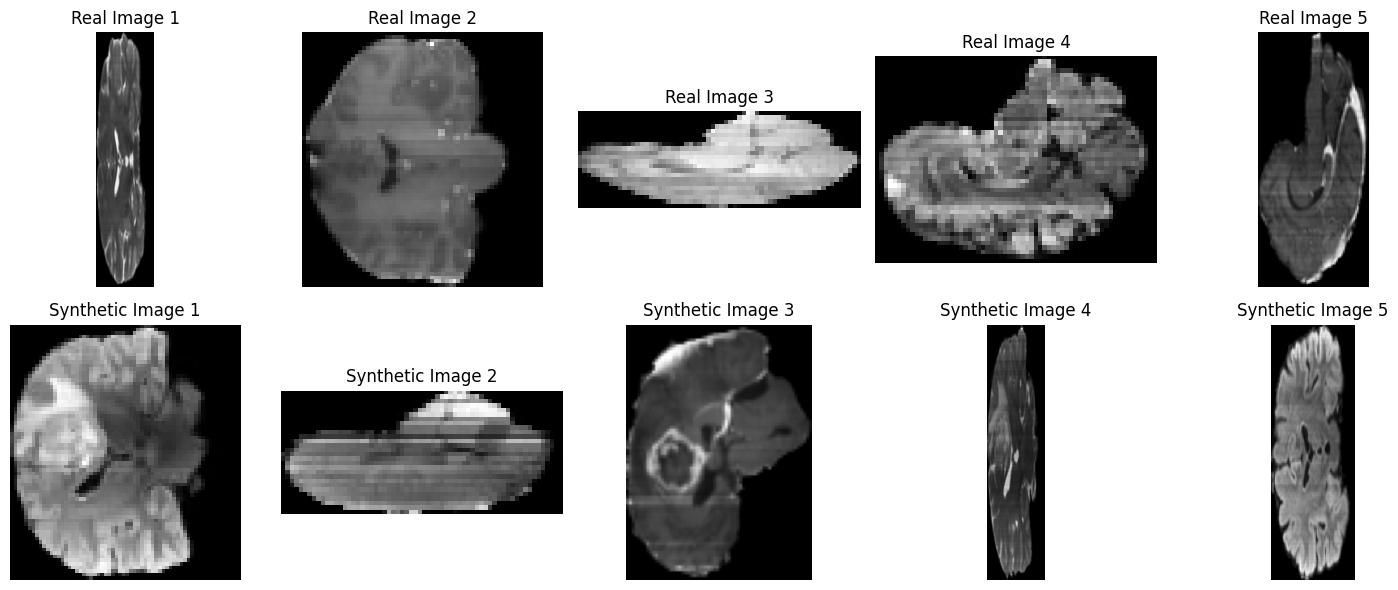

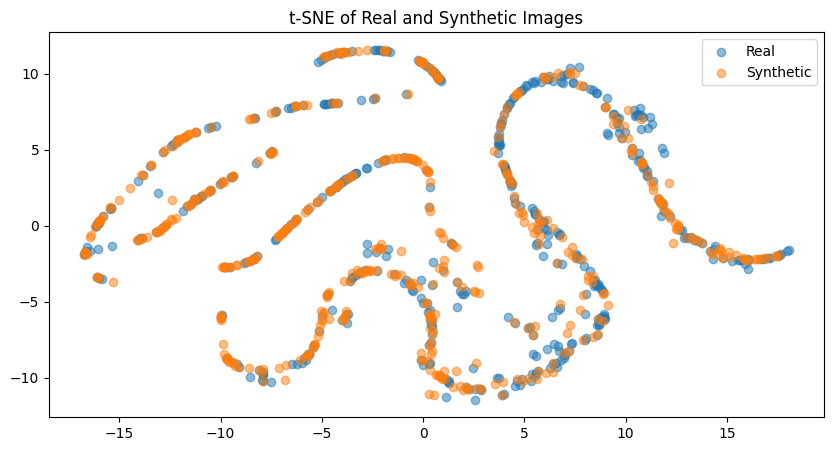

FID Score: 255850.36580554344


In [7]:
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import numpy as np
from sklearn.manifold import TSNE
from scipy.linalg import sqrtm
from numpy import cov, trace, iscomplexobj
from monai.networks.nets import resnet18
from torch.utils.data import DataLoader

# Function to plot sample images
def plot_samples(real_images, synthetic_images, n=5):
    fig, axes = plt.subplots(2, n, figsize=(15, 6))
    for i in range(n):
        real_image = nib.load(real_images[i]).get_fdata()
        synthetic_image = nib.load(synthetic_images[i]).get_fdata()
        
        axes[0, i].imshow(real_image[:, :, real_image.shape[2] // 2], cmap='gray')
        axes[0, i].set_title(f'Real Image {i+1}')
        axes[0, i].axis('off')

        axes[1, i].imshow(synthetic_image[:, :, synthetic_image.shape[2] // 2], cmap='gray')
        axes[1, i].set_title(f'Synthetic Image {i+1}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Function to extract features using a pre-trained model
def extract_features(image_paths, model, device):
    model.eval()
    features = []
    with torch.no_grad():
        for path in image_paths:
            image = nib.load(path).get_fdata()
            image = torch.tensor(image).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float)
            feature = model(image).cpu().numpy().flatten()
            features.append(feature)
    return np.array(features)

# Function to calculate FID score
def calculate_fid(real_features, synthetic_features):
    mu1, sigma1 = np.mean(real_features, axis=0), cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(synthetic_features, axis=0), cov(synthetic_features, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    if iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Function to visualize t-SNE results
def tsne_visualization(real_features, synthetic_features):
    all_features = np.concatenate((real_features, synthetic_features))
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    tsne_results = tsne.fit_transform(all_features)

    plt.figure(figsize=(10, 5))
    plt.scatter(tsne_results[:len(real_features), 0], tsne_results[:len(real_features), 1], label='Real', alpha=0.5)
    plt.scatter(tsne_results[len(real_features):, 0], tsne_results[len(real_features):, 1], label='Synthetic', alpha=0.5)
    plt.legend()
    plt.title('t-SNE of Real and Synthetic Images')
    plt.show()

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use a pre-trained model to extract features
model = resnet18(
    spatial_dims=3, 
    n_input_channels=1, 
    pretrained=True, 
    progress=True, 
    feed_forward=False, 
    shortcut_type='A', 
    bias_downsample=False
).to(device)
model.fc = nn.Identity()  # Remove the final classification layer

# Example usage
real_image_paths = train_files[:500]  # Replace with actual real image paths
synthetic_image_paths = combined_files[:500]  # Replace with actual synthetic image paths

# Extract features
real_features = extract_features(real_image_paths, model, device)
synthetic_features = extract_features(synthetic_image_paths, model, device)

# Plot samples
plot_samples(real_image_paths, synthetic_image_paths, n=5)

# t-SNE visualization
tsne_visualization(real_features, synthetic_features)

# Calculate and print FID score
fid_score = calculate_fid(real_features, synthetic_features)
print(f'FID Score: {fid_score}')


In [8]:
train_files, val_files, train_labels, val_labels = train_test_split(data, data_labels, test_size=0.3, random_state=42)
train_ds = GliomaDataset(train_files, train_labels, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4)
val_ds = GliomaDataset(val_files, val_labels, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=8, num_workers=4)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import resnet50

# Define a custom model based on resnet50
class CustomResNet18(nn.Module):
    def __init__(self):
        super(CustomResNet18, self).__init__()
        self.resnet = resnet18(spatial_dims=3, n_input_channels=1, shortcut_type='A', bias_downsample=False, feed_forward=False, pretrained=True)
        # Check if self.resnet.fc exists, and if not, create one
        if hasattr(self.resnet, 'fc') and self.resnet.fc is not None:
            in_features = self.resnet.fc.in_features
        else:
            in_features = 512  # Default size if fc is not found, might need adjustment based on the actual architecture
        
        self.resnet.fc = nn.Linear(in_features, 1)  # Adjust the final layer to output a single value        
        # Freeze all layers except the final layer
        #for param in self.resnet.parameters():
            #param.requires_grad = False
        
        # Ensure the parameters of the final fully connected layer are trainable
        #for param in self.resnet.fc.parameters():
            #param.requires_grad = True
        
    def forward(self, x):
        x = self.resnet(x)
        return x

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomResNet18().to(device)

# Define loss and optimizer
loss_function = nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
# Training loop (same as your previous setup)
# Initialize lists to store metrics for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.manifold import TSNE
import numpy as np

train_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

max_epochs = 60
val_interval = 2
best_metric = -1
best_metric_epoch = -1

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    batch_losses = []  # To store batch losses within the epoch
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data
        inputs, labels = inputs.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(-1)  # Ensure outputs are reshaped correctly to match the shape of labels
        loss = loss_function(outputs, labels)  # Adjusting the shape of outputs
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        batch_losses.append(loss.item())  # Append batch loss
    epoch_loss /= step
    train_losses.append(epoch_loss)  # Append epoch loss
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            all_labels = []
            all_predictions = []
            for val_data in val_loader:
                val_images, val_labels = val_data
                val_images, val_labels = val_images.to(device), val_labels.to(device).float()
                val_outputs = model(val_images)
                val_outputs = val_outputs.view(-1)  # Ensure outputs are reshaped correctly
                value = torch.sigmoid(val_outputs)  # Adjusting the shape of outputs
                value = (value > 0.5).float()
                all_labels.extend(val_labels.cpu().numpy())
                all_predictions.extend(value.cpu().numpy())
                metric_sum += (value == val_labels).sum().item()
                metric_count += len(val_labels)
            metric = metric_sum / metric_count
            precision = precision_score(all_labels, all_predictions)
            recall = recall_score(all_labels, all_predictions)
            f1 = f1_score(all_labels, all_predictions)
            val_accuracies.append(metric)  # Append validation accuracy
            val_precisions.append(precision)  # Append validation precision
            val_recalls.append(recall)  # Append validation recall
            val_f1_scores.append(f1)  # Append validation F1 score

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("saved new best metric model")
            print(f"current epoch: {epoch + 1} current accuracy: {metric:.4f} best accuracy: {best_metric:.4f} at epoch: {best_metric_epoch}")
            print(f"precision: {precision:.4f}, recall: {recall:.4f}, f1: {f1:.4f}")


----------
epoch 1/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 1 average loss: 0.6850
----------
epoch 2/60
epoch 2 average loss: 0.5902
saved new best metric model
current epoch: 2 current accuracy: 0.7739 best accuracy: 0.7739 at epoch: 2
precision: 0.7361, recall: 0.8540, f1: 0.7906
----------
epoch 3/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 3 average loss: 0.4796
----------
epoch 4/60
epoch 4 average loss: 0.4251
saved new best metric model
current epoch: 4 current accuracy: 0.8504 best accuracy: 0.8504 at epoch: 4
precision: 0.8027, recall: 0.9290, f1: 0.8612
----------
epoch 5/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 5 average loss: 0.3745
----------
epoch 6/60
epoch 6 average loss: 0.3416
saved new best metric model
current epoch: 6 current accuracy: 0.8522 best accuracy: 0.8522 at epoch: 6
precision: 0.8862, recall: 0.8080, f1: 0.8453
----------
epoch 7/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 7 average loss: 0.3239
----------
epoch 8/60
epoch 8 average loss: 0.3006
saved new best metric model
current epoch: 8 current accuracy: 0.8706 best accuracy: 0.8706 at epoch: 8
precision: 0.8350, recall: 0.9236, f1: 0.8771
----------
epoch 9/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 9 average loss: 0.2841
----------
epoch 10/60
epoch 10 average loss: 0.2699
saved new best metric model
current epoch: 10 current accuracy: 0.8751 best accuracy: 0.8751 at epoch: 10
precision: 0.8504, recall: 0.9104, f1: 0.8794
----------
epoch 11/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 11 average loss: 0.2569
----------
epoch 12/60
epoch 12 average loss: 0.2400
current epoch: 12 current accuracy: 0.8738 best accuracy: 0.8751 at epoch: 10
precision: 0.9268, recall: 0.8116, f1: 0.8654
----------
epoch 13/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 13 average loss: 0.2360
----------
epoch 14/60
epoch 14 average loss: 0.2210
saved new best metric model
current epoch: 14 current accuracy: 0.8917 best accuracy: 0.8917 at epoch: 14
precision: 0.8624, recall: 0.9322, f1: 0.8959
----------
epoch 15/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 15 average loss: 0.2100
----------
epoch 16/60
epoch 16 average loss: 0.2025
saved new best metric model
current epoch: 16 current accuracy: 0.8929 best accuracy: 0.8929 at epoch: 16
precision: 0.9476, recall: 0.8317, f1: 0.8859
----------
epoch 17/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 17 average loss: 0.1930
----------
epoch 18/60
epoch 18 average loss: 0.1760
saved new best metric model
current epoch: 18 current accuracy: 0.8995 best accuracy: 0.8995 at epoch: 18
precision: 0.9295, recall: 0.8644, f1: 0.8958
----------
epoch 19/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 19 average loss: 0.1683
----------
epoch 20/60
epoch 20 average loss: 0.1653
saved new best metric model
current epoch: 20 current accuracy: 0.9193 best accuracy: 0.9193 at epoch: 20
precision: 0.9068, recall: 0.9345, f1: 0.9205
----------
epoch 21/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 21 average loss: 0.1447
----------
epoch 22/60
epoch 22 average loss: 0.1430
saved new best metric model
current epoch: 22 current accuracy: 0.9277 best accuracy: 0.9277 at epoch: 22
precision: 0.9384, recall: 0.9154, f1: 0.9268
----------
epoch 23/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 23 average loss: 0.1326
----------
epoch 24/60
epoch 24 average loss: 0.1254
saved new best metric model
current epoch: 24 current accuracy: 0.9409 best accuracy: 0.9409 at epoch: 24
precision: 0.9288, recall: 0.9550, f1: 0.9417
----------
epoch 25/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 25 average loss: 0.1210
----------
epoch 26/60
epoch 26 average loss: 0.1088
saved new best metric model
current epoch: 26 current accuracy: 0.9450 best accuracy: 0.9450 at epoch: 26
precision: 0.9394, recall: 0.9513, f1: 0.9453
----------
epoch 27/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 27 average loss: 0.1066
----------
epoch 28/60
epoch 28 average loss: 0.1065
saved new best metric model
current epoch: 28 current accuracy: 0.9463 best accuracy: 0.9463 at epoch: 28
precision: 0.9529, recall: 0.9390, f1: 0.9459
----------
epoch 29/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 29 average loss: 0.0975
----------
epoch 30/60
epoch 30 average loss: 0.0907
saved new best metric model
current epoch: 30 current accuracy: 0.9525 best accuracy: 0.9525 at epoch: 30
precision: 0.9539, recall: 0.9509, f1: 0.9524
----------
epoch 31/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 31 average loss: 0.0914
----------
epoch 32/60
epoch 32 average loss: 0.0828
current epoch: 32 current accuracy: 0.9481 best accuracy: 0.9525 at epoch: 30
precision: 0.9502, recall: 0.9459, f1: 0.9480
----------
epoch 33/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 33 average loss: 0.0801
----------
epoch 34/60
epoch 34 average loss: 0.0773
current epoch: 34 current accuracy: 0.9377 best accuracy: 0.9525 at epoch: 30
precision: 0.9094, recall: 0.9722, f1: 0.9398
----------
epoch 35/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 35 average loss: 0.0751
----------
epoch 36/60
epoch 36 average loss: 0.0691
saved new best metric model
current epoch: 36 current accuracy: 0.9534 best accuracy: 0.9534 at epoch: 36
precision: 0.9384, recall: 0.9704, f1: 0.9541
----------
epoch 37/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 37 average loss: 0.0662
----------
epoch 38/60
epoch 38 average loss: 0.0720
saved new best metric model
current epoch: 38 current accuracy: 0.9538 best accuracy: 0.9538 at epoch: 38
precision: 0.9540, recall: 0.9536, f1: 0.9538
----------
epoch 39/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 39 average loss: 0.0591
----------
epoch 40/60
epoch 40 average loss: 0.0652
current epoch: 40 current accuracy: 0.9525 best accuracy: 0.9538 at epoch: 38
precision: 0.9577, recall: 0.9468, f1: 0.9522
----------
epoch 41/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 41 average loss: 0.0543
----------
epoch 42/60
epoch 42 average loss: 0.0525
saved new best metric model
current epoch: 42 current accuracy: 0.9588 best accuracy: 0.9588 at epoch: 42
precision: 0.9603, recall: 0.9572, f1: 0.9588
----------
epoch 43/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 43 average loss: 0.0525
----------
epoch 44/60
epoch 44 average loss: 0.0521
saved new best metric model
current epoch: 44 current accuracy: 0.9593 best accuracy: 0.9593 at epoch: 44
precision: 0.9633, recall: 0.9550, f1: 0.9591
----------
epoch 45/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 45 average loss: 0.0524
----------
epoch 46/60
epoch 46 average loss: 0.0463
current epoch: 46 current accuracy: 0.9534 best accuracy: 0.9593 at epoch: 44
precision: 0.9459, recall: 0.9618, f1: 0.9538
----------
epoch 47/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 47 average loss: 0.0478
----------
epoch 48/60
epoch 48 average loss: 0.0399
current epoch: 48 current accuracy: 0.9554 best accuracy: 0.9593 at epoch: 44
precision: 0.9509, recall: 0.9604, f1: 0.9556
----------
epoch 49/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 49 average loss: 0.0443
----------
epoch 50/60
epoch 50 average loss: 0.0428
current epoch: 50 current accuracy: 0.9591 best accuracy: 0.9593 at epoch: 44
precision: 0.9557, recall: 0.9627, f1: 0.9592
----------
epoch 51/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 51 average loss: 0.0436
----------
epoch 52/60
epoch 52 average loss: 0.0397
current epoch: 52 current accuracy: 0.9575 best accuracy: 0.9593 at epoch: 44
precision: 0.9471, recall: 0.9691, f1: 0.9579
----------
epoch 53/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 53 average loss: 0.0392
----------
epoch 54/60
epoch 54 average loss: 0.0371
current epoch: 54 current accuracy: 0.9545 best accuracy: 0.9593 at epoch: 44
precision: 0.9382, recall: 0.9732, f1: 0.9553
----------
epoch 55/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 55 average loss: 0.0411
----------
epoch 56/60
epoch 56 average loss: 0.0323
current epoch: 56 current accuracy: 0.9577 best accuracy: 0.9593 at epoch: 44
precision: 0.9479, recall: 0.9686, f1: 0.9581
----------
epoch 57/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 57 average loss: 0.0345
----------
epoch 58/60
epoch 58 average loss: 0.0330
current epoch: 58 current accuracy: 0.9568 best accuracy: 0.9593 at epoch: 44
precision: 0.9490, recall: 0.9654, f1: 0.9571
----------
epoch 59/60


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 59 average loss: 0.0352
----------
epoch 60/60
epoch 60 average loss: 0.0294
current epoch: 60 current accuracy: 0.9559 best accuracy: 0.9593 at epoch: 44
precision: 0.9665, recall: 0.9445, f1: 0.9554


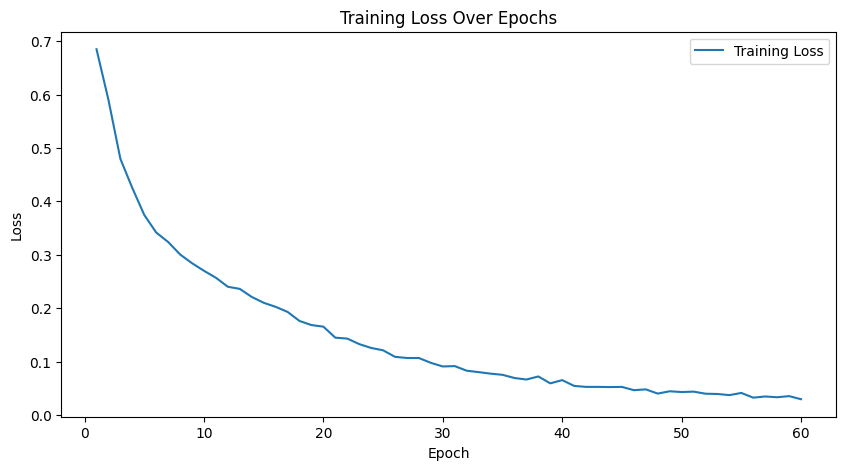

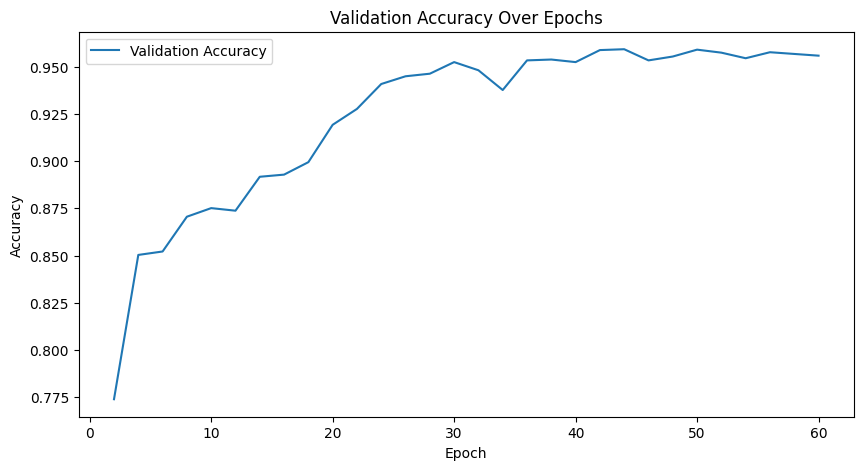

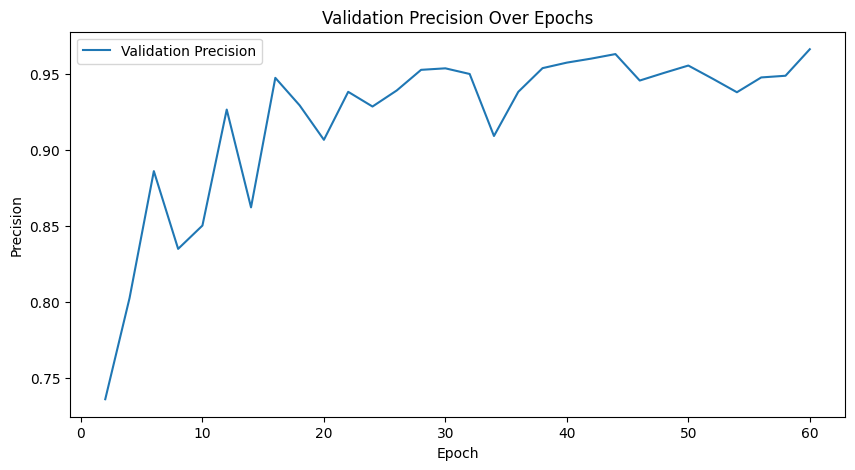

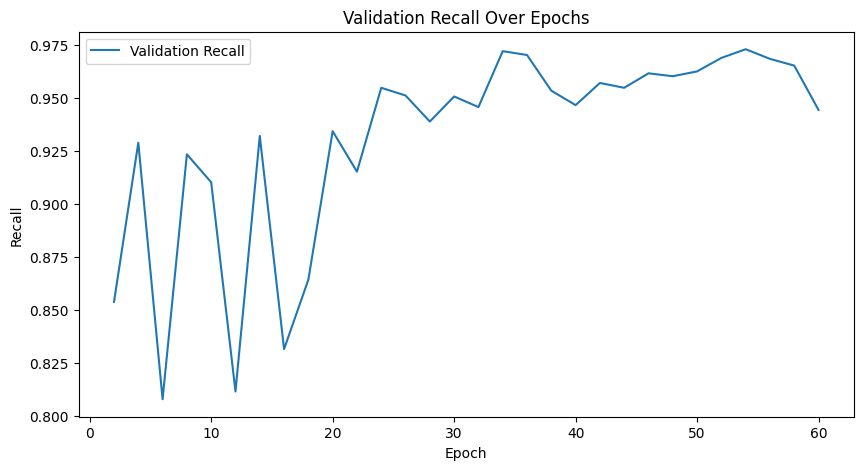

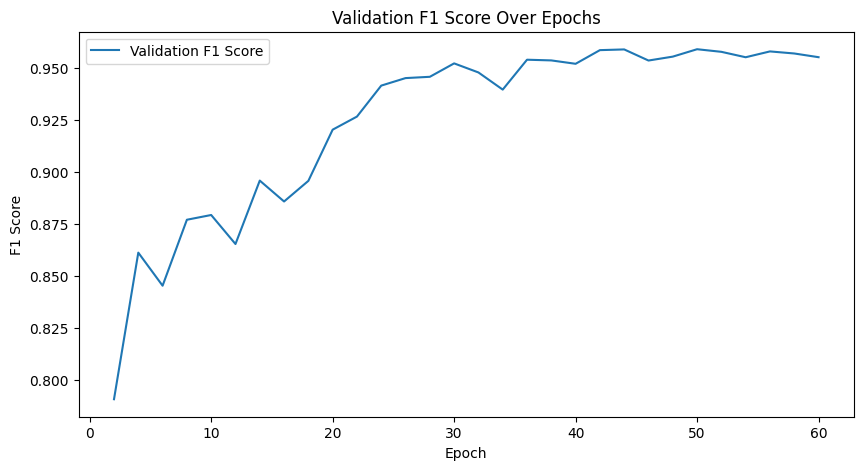

In [10]:

# Plot training loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(val_interval, max_epochs + 1, val_interval), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot validation precision over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(val_interval, max_epochs + 1, val_interval), val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Validation Precision Over Epochs')
plt.legend()
plt.show()

# Plot validation recall over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(val_interval, max_epochs + 1, val_interval), val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Validation Recall Over Epochs')
plt.legend()
plt.show()

# Plot validation F1 score over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(val_interval, max_epochs + 1, val_interval), val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score Over Epochs')
plt.legend()
plt.show()



In [11]:
# Load the best model
model.load_state_dict(torch.load("best_metric_model.pth"))

# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    metric_sum = 0.0
    metric_count = 0
    for val_data in val_loader:
        val_images, val_labels = val_data
        val_images, val_labels = val_images.to(device), val_labels.to(device).float()
        val_outputs = model(val_images)
        value = torch.sigmoid(val_outputs.squeeze())
        value = (value > 0.5).float()
        all_labels.extend(val_labels.cpu().numpy())
        all_predictions.extend(value.cpu().numpy())
        metric_sum += (value == val_labels).sum().item()
        metric_count += len(val_labels)
    accuracy = metric_sum / metric_count
    print(f"Validation Accuracy: {accuracy:.4f}")



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Accuracy: 0.9593


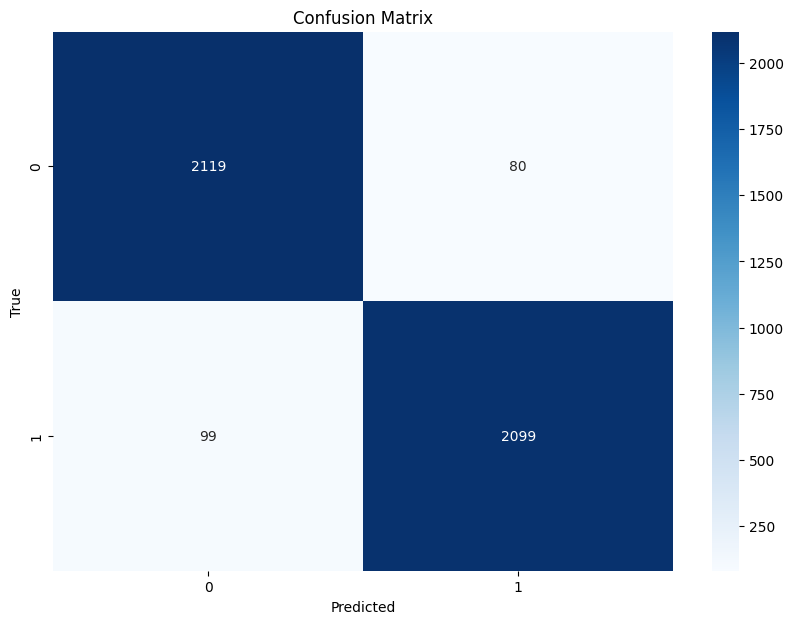

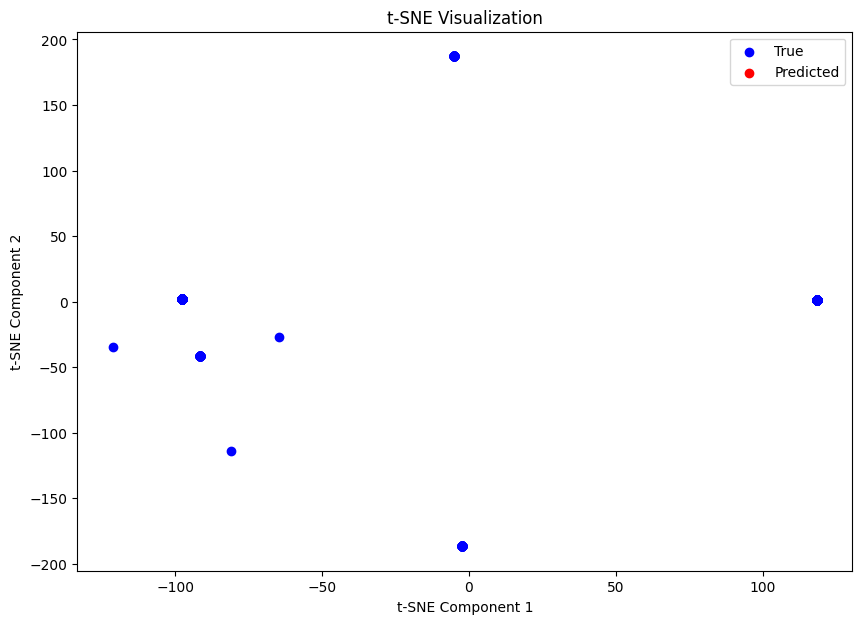

Final Precision: 0.9633
Final Recall: 0.9550
Final F1 Score: 0.9591


In [12]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Compute t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(np.vstack((all_labels, all_predictions)).T)
plt.figure(figsize=(10, 7))
plt.scatter(tsne_result[:len(all_labels), 0], tsne_result[:len(all_labels), 1], c='blue', label='True')
plt.scatter(tsne_result[len(all_labels):, 0], tsne_result[len(all_labels):, 1], c='red', label='Predicted')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization')
plt.legend()
plt.show()

# Calculate and print final precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1:.4f}')
